# 1. Intel Classification and Ade20K Outdoors Dataset Machine Learning

In [1]:
import os

def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([file for file in files if file.endswith('.png') or file.endswith('.jpg')])
    return count

# ADE20K Outdoors
ade20k_root_path = r'C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\ADE20K Outdoors'
ade20k_annotations_train_path = os.path.join(ade20k_root_path, 'annotations', 'training')
ade20k_images_train_path = os.path.join(ade20k_root_path, 'images', 'training')

ade20k_annotations_train_count = count_images_in_folder(ade20k_annotations_train_path)
ade20k_images_train_count = count_images_in_folder(ade20k_images_train_path)

# Intel Image Classification
intel_root_path = r'C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\Intel Classification'
intel_seg_test_path = os.path.join(intel_root_path, 'seg_test','seg_test')

intel_buildings_count = count_images_in_folder(os.path.join(intel_seg_test_path, 'buildings'))
intel_forest_count = count_images_in_folder(os.path.join(intel_seg_test_path, 'forest'))
intel_glacier_count = count_images_in_folder(os.path.join(intel_seg_test_path, 'glacier'))
intel_mountain_count = count_images_in_folder(os.path.join(intel_seg_test_path, 'mountain'))
intel_sea_count = count_images_in_folder(os.path.join(intel_seg_test_path, 'sea'))
intel_street_count = count_images_in_folder(os.path.join(intel_seg_test_path, 'street'))

# Print results
print("ADE20K Outdoors - Training Annotations Count:", ade20k_annotations_train_count)
print("ADE20K Outdoors - Training Images Count:", ade20k_images_train_count)
print("Intel Image Classification - seg_test Buildings Count:", intel_buildings_count)
print("Intel Image Classification - seg_test Forest Count:", intel_forest_count)
print("Intel Image Classification - seg_test Glacier Count:", intel_glacier_count)
print("Intel Image Classification - seg_test Mountain Count:", intel_mountain_count)
print("Intel Image Classification - seg_test Sea Count:", intel_sea_count)
print("Intel Image Classification - seg_test Street Count:", intel_street_count)

ADE20K Outdoors - Training Annotations Count: 5000
ADE20K Outdoors - Training Images Count: 4999
Intel Image Classification - seg_test Buildings Count: 437
Intel Image Classification - seg_test Forest Count: 474
Intel Image Classification - seg_test Glacier Count: 553
Intel Image Classification - seg_test Mountain Count: 525
Intel Image Classification - seg_test Sea Count: 510
Intel Image Classification - seg_test Street Count: 501


## 2.Load and Preprocess the Data with Train Test Split

In [85]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to check and remove corrupted images
def check_and_remove_corrupted_images(directory):
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (IOError, SyntaxError):
            print(f"Corrupted or invalid image file found and deleted: {file_path}")
            os.remove(file_path)

# Function to organize ADE20K images into dummy class subdirectory
def organize_ade20k_images(data_dir):
    all_images_path = os.path.join(data_dir, 'all_images')
    dummy_class_path = os.path.join(all_images_path, 'dummy_class')

    if not os.path.exists(all_images_path):
        os.makedirs(all_images_path)
    if not os.path.exists(dummy_class_path):
        os.makedirs(dummy_class_path)

    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                shutil.move(os.path.join(root, file), os.path.join(dummy_class_path, file))

    check_and_remove_corrupted_images(dummy_class_path)
    return all_images_path

# Path to ADE20K images
ade20k_images_train_path = r'C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\ADE20K Outdoors\images\training'
ade20k_images_train_path = organize_ade20k_images(ade20k_images_train_path)

# Intel dataset loading
intel_seg_test_path = r'C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\Intel Classification\seg_test\seg_test'

# Data generator for Intel dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
train_gen = datagen.flow_from_directory(intel_seg_test_path, target_size=(150, 150), batch_size=32, class_mode='categorical', subset='training')
val_gen = datagen.flow_from_directory(intel_seg_test_path, target_size=(150, 150), batch_size=32, class_mode='categorical', subset='validation')

Found 2102 images belonging to 6 classes.
Found 898 images belonging to 6 classes.


## 3. Build the Baseline Model using supervised learning for Intel Dataset

In [86]:
# Function to build a baseline model
def build_baseline_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Intel dataset baseline model
input_shape = (150, 150, 3)
num_classes_intel = train_gen.num_classes

model_intel = build_baseline_model(input_shape, num_classes_intel)
model_intel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_intel = model_intel.fit(train_gen, validation_data=val_gen, epochs=10)






Epoch 1/10


C:\Users\benja\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - accuracy: 0.3432 - loss: 1.8536 - val_accuracy: 0.5802 - val_loss: 1.0607
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 308ms/step - accuracy: 0.5966 - loss: 1.0417 - val_accuracy: 0.6303 - val_loss: 1.0262
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - accuracy: 0.6477 - loss: 0.9310 - val_accuracy: 0.6737 - val_loss: 0.9295
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - accuracy: 0.7146 - loss: 0.7444 - val_accuracy: 0.6960 - val_loss: 0.8592
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.7520 - loss: 0.6495 - val_accuracy: 0.6882 - val_loss: 0.9236
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - accuracy: 0.8392 - loss: 0.4590 - val_accuracy: 0.6904 - val_loss: 0.8391
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - accuracy: 0.8730 - loss: 0.3735 - val_accuracy: 0.7094 - val_loss: 0.9450
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.8958 - loss: 0.2967 - val_accuracy: 0.694

## 4.Building the Baseline model using unsupervised learning on ADE20K Dataset

In [29]:

# Load VGG16 model pre-trained on ImageNet
from keras.applications import VGG16
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np


# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Data generator to load ADE20K images
datagen_ade20k = ImageDataGenerator(rescale=1./255)
data_gen_ade20k = datagen_ade20k.flow_from_directory(
    ade20k_images_train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,  # No class labels
    shuffle=False
)

# Extract features using VGG16
features_ade20k = feature_extractor.predict(data_gen_ade20k)
features_flattened = features_ade20k.reshape(features_ade20k.shape[0], -1)

# Apply KMeans clustering
n_clusters = 5  # Choose the number of clusters based on your analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_flattened)

# Convert generator output to numpy array for easy access
images = []
for i in range(len(data_gen_ade20k)):
    batch = data_gen_ade20k[i]  # Get the i-th batch
    for img in batch:
        images.append(img)  # Add each image from the batch to the list

images = np.array(images)  # Convert the list to numpy array


Found 4999 images belonging to 1 classes.


C:\Users\benja\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 134s 851ms/step


## 5.Evaluate the Model for Intel Dataset

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

# Evaluate the model on the validation data
intel_eval_results = model_intel.evaluate(val_gen)
print(f"Intel Dataset - Loss: {intel_eval_results[0]}, Accuracy: {intel_eval_results[1]}")

# Make predictions on the validation set
y_pred_intel = model_intel.predict(val_gen)
y_pred_intel_classes = np.argmax(y_pred_intel, axis=1)
y_true_intel = val_gen.classes

# Confusion Matrix and Classification Report
print("Confusion Matrix for Intel Dataset:")
print(confusion_matrix(y_true_intel, y_pred_intel_classes))

print("\nClassification Report for Intel Dataset:")
print(classification_report(y_true_intel, y_pred_intel_classes, target_names=val_gen.class_indices.keys()))

# F1 Scores
f1_macro_intel = f1_score(y_true_intel, y_pred_intel_classes, average='macro')
f1_micro_intel = f1_score(y_true_intel, y_pred_intel_classes, average='micro')

print(f"Intel Dataset - F1 Macro: {f1_macro_intel}, F1 Micro: {f1_micro_intel}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.6427 - loss: 0.9389
Intel Dataset - Loss: 0.8836820721626282, Accuracy: 0.679287314414978
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step
Confusion Matrix for Intel Dataset:
[[21 11 26 29 18 26]
 [26 17 22 29 16 32]
 [30 20 42 21 10 42]
 [11 25 38 23  9 51]
 [25 17 36 18 18 39]
 [17 16 41 19 19 38]]

Classification Report for Intel Dataset:
              precision    recall  f1-score   support

   buildings       0.16      0.16      0.16       131
      forest       0.16      0.12      0.14       142
     glacier       0.20      0.25      0.23       165
    mountain       0.17      0.15      0.16       157
         sea       0.20      0.12      0.15       153
      street       0.17      0.25      0.20       150

    accuracy                           0.18       898
   macro avg       0.18      0.18      0.17       898
weighted avg       0.18      0.18      0.17       898

Intel Dataset - F1 Macro: 0.17160918267703584, F1 Micro: 0.1770601

## 6.Evaluate the model for ADE20K Dataset

Silhouette Score for ADE20K Clusters: -0.001903949654661119


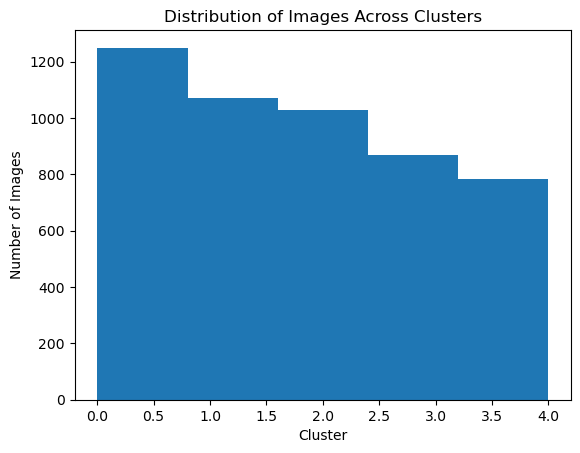

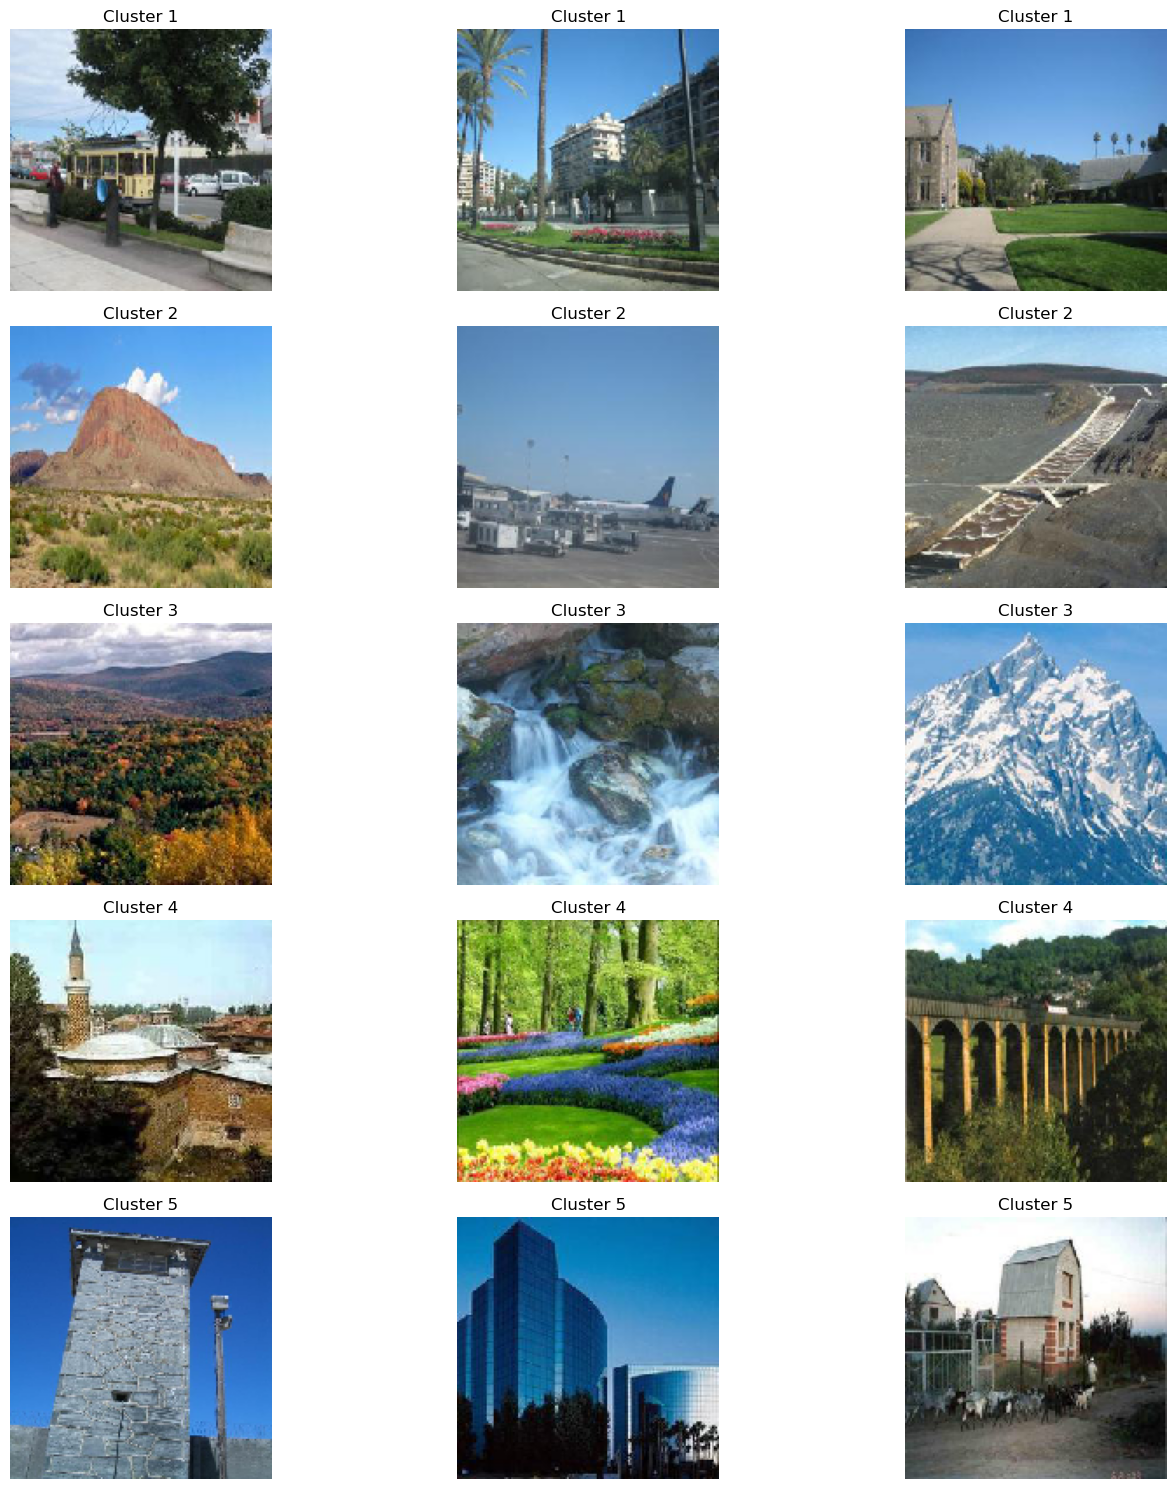

In [30]:
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(features_flattened, cluster_labels)
print(f"Silhouette Score for ADE20K Clusters: {silhouette_avg}")

# Visualize Clusters
plt.hist(cluster_labels, bins=n_clusters)
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.title("Distribution of Images Across Clusters")
plt.show()

# Function to visualize samples from each cluster
def plot_cluster_samples(images, cluster_labels, n_clusters=5, samples_per_cluster=3):
    fig, axes = plt.subplots(n_clusters, samples_per_cluster, figsize=(15, n_clusters * 3))
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, size=min(samples_per_cluster, len(cluster_indices)), replace=False)
        for i, idx in enumerate(selected_indices):
            img = images[idx]
            ax = axes[cluster, i]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Cluster {cluster + 1}")
    plt.tight_layout()
    plt.show()

# Visualize some samples from each cluster
plot_cluster_samples(images, cluster_labels, n_clusters=n_clusters)

## 7. Visualize the Results for Supervised learning of Intel Dataset

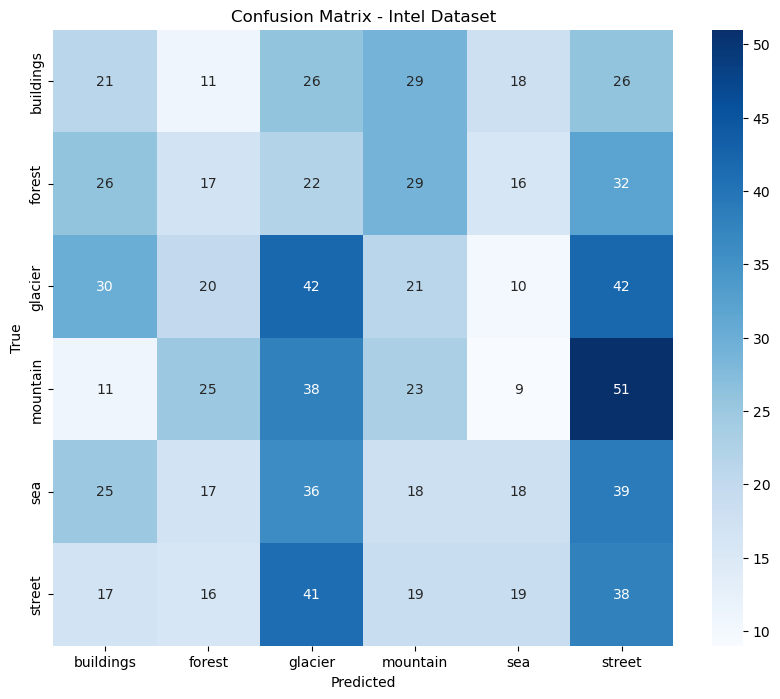

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, data_gen, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    class_names = list(data_gen.class_indices.keys())
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


# Plot confusion matrix for Intel dataset
plot_confusion_matrix(y_true_intel, y_pred_intel_classes, data_gen_intel, title='Confusion Matrix - Intel Dataset')


In [49]:
from sklearn.metrics import classification_report

# Generate classification report for Intel dataset
report_intel = classification_report(y_true_intel, y_pred_intel_classes, target_names=list(data_gen_intel.class_indices.keys()))
print("Classification Report - Intel Dataset:\n", report_intel)


Classification Report - Intel Dataset:
               precision    recall  f1-score   support

   buildings       0.16      0.16      0.16       131
      forest       0.16      0.12      0.14       142
     glacier       0.20      0.25      0.23       165
    mountain       0.17      0.15      0.16       157
         sea       0.20      0.12      0.15       153
      street       0.17      0.25      0.20       150

    accuracy                           0.18       898
   macro avg       0.18      0.18      0.17       898
weighted avg       0.18      0.18      0.17       898



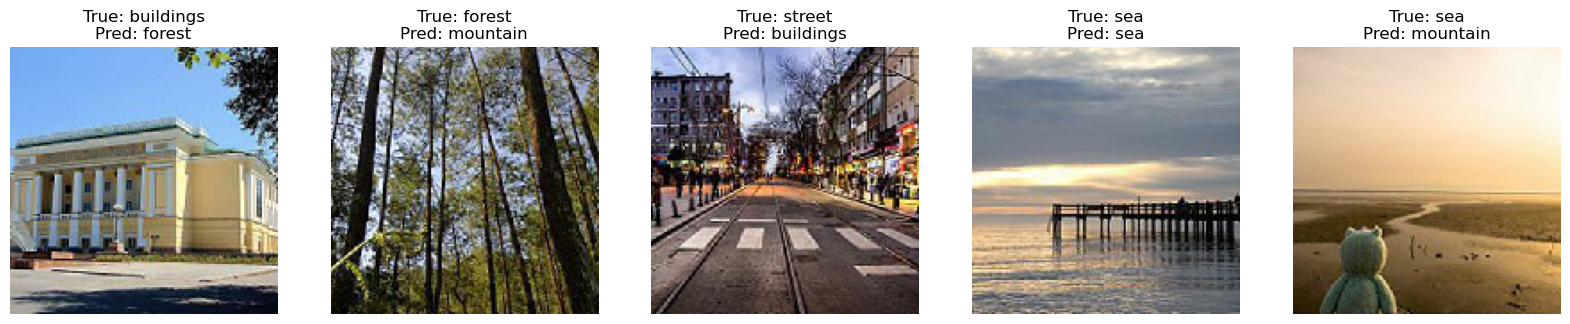

In [31]:
import random

# Visualize misclassified samples for Intel dataset
misclassified_indices_intel = np.where(y_pred_intel_classes != y_true_intel)[0]
random_misclassified_intel = random.sample(list(misclassified_indices_intel), 5)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(random_misclassified_intel):
    img = X_test_intel[idx]
    true_label = list(data_gen_intel.class_indices.keys())[list(data_gen_intel.class_indices.values()).index(y_test_intel[idx].argmax())]
    pred_label = list(data_gen_intel.class_indices.keys())[list(data_gen_intel.class_indices.values()).index(y_pred_intel[idx].argmax())]
    axs[i].imshow(img)
    axs[i].set_title(f"True: {true_label}\nPred: {pred_label}")
    axs[i].axis('off')
plt.show()

## 8. Improving the Baselines of Intel Dataset

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Improved Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,^
    rotation_range=40,  # Increased rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',  # Fill mode for augmented images
    validation_split=0.3
)

# Prepare Data Generators
train_gen = datagen.flow_from_directory(
    intel_seg_test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_gen = datagen.flow_from_directory(
    intel_seg_test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Load Pre-trained VGG16 Model with Top Layers Removed
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Unfreeze some layers in VGG16 for Fine-tuning
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

# Add Custom Layers for Fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_gen.num_classes, activation='softmax')(x)

# Compile the Model
model_refined = Model(inputs=base_model.input, outputs=outputs)
model_refined.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping and Learning Rate Reduction on Plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the Refined Model with Callbacks
history_refined = model_refined.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Refined Model
eval_results_refined = model_refined.evaluate(val_gen)
print(f"Refined Model - Intel Dataset - Loss: {eval_results_refined[0]}, Accuracy: {eval_results_refined[1]}")

# Predict on the Validation Set
y_pred_refined = model_refined.predict(val_gen)
y_pred_classes_refined = np.argmax(y_pred_refined, axis=1)
y_true_intel = val_gen.classes

# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Confusion Matrix for Intel Dataset (Refined Model):")
print(confusion_matrix(y_true_intel, y_pred_classes_refined))

print("\nClassification Report for Intel Dataset (Refined Model):")
print(classification_report(y_true_intel, y_pred_classes_refined, target_names=val_gen.class_indices.keys()))

# F1 Scores
f1_macro_refined = f1_score(y_true_intel, y_pred_classes_refined, average='macro')
f1_micro_refined = f1_score(y_true_intel, y_pred_classes_refined, average='micro')

print(f"Intel Dataset - F1 Macro (Refined Model): {f1_macro_refined}, F1 Micro (Refined Model): {f1_micro_refined}")


Found 2102 images belonging to 6 classes.
Found 898 images belonging to 6 classes.
Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.4478 - loss: 4.7398 - val_accuracy: 0.7283 - val_loss: 3.9864 - learning_rate: 1.0000e-04
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.6991 - loss: 3.8539 - val_accuracy: 0.7416 - val_loss: 3.5375 - learning_rate: 1.0000e-04
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.7849 - loss: 3.3400 - val_accuracy: 0.7639 - val_loss: 3.1611 - learning_rate: 1.0000e-04
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - accuracy: 0.8098 - loss: 3.0033 - val_accuracy: 0.7584 - val_loss: 2.9798 - learning_rate: 1.0000e-04
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.8161 - loss: 2.7368 - val_accuracy: 0.7617 - val_loss: 2.7162 - learning_rate: 1.0000e-04
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.8406 - loss: 2.4260 - val_accuracy: 0.7951 - val_loss: 2.4175 - learning_rate

In [53]:

# Make predictions on the validation set
y_pred_refined = model_refined.predict(val_gen)
y_pred_classes_refined = np.argmax(y_pred_refined, axis=1)
y_true_intel = val_gen.classes

# Confusion Matrix
print("Confusion Matrix for Intel Dataset (Refined Model):")
conf_matrix = confusion_matrix(y_true_intel, y_pred_classes_refined)
print(conf_matrix)

# Classification Report
print("\nClassification Report for Intel Dataset (Refined Model):")
class_report = classification_report(y_true_intel, y_pred_classes_refined, target_names=val_gen.class_indices.keys())
print(class_report)

# F1 Scores
f1_macro_refined = f1_score(y_true_intel, y_pred_classes_refined, average='macro')
f1_micro_refined = f1_score(y_true_intel, y_pred_classes_refined, average='micro')

print(f"Intel Dataset - F1 Macro (Refined Model): {f1_macro_refined}, F1 Micro (Refined Model): {f1_micro_refined}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 862ms/step
Confusion Matrix for Intel Dataset (Refined Model):
[[17 26 26 22 17 23]
 [13 23 31 26 20 29]
 [22 22 30 21 33 37]
 [24 28 40 14 27 24]
 [19 27 27 27 28 25]
 [20 25 22 33 24 26]]

Classification Report for Intel Dataset (Refined Model):
              precision    recall  f1-score   support

   buildings       0.15      0.13      0.14       131
      forest       0.15      0.16      0.16       142
     glacier       0.17      0.18      0.18       165
    mountain       0.10      0.09      0.09       157
         sea       0.19      0.18      0.19       153
      street       0.16      0.17      0.17       150

    accuracy                           0.15       898
   macro avg       0.15      0.15      0.15       898
weighted avg       0.15      0.15      0.15       898

Intel Dataset - F1 Macro (Refined Model): 0.15258832346238616, F1 Micro (Refined Model): 0.15367483296213807


## 9.Improving baseline of ADE20K Dataset

In [87]:
from keras.applications import VGG16
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading
import numpy as np

# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Data generator to load ADE20K images
datagen_ade20k = ImageDataGenerator(rescale=1./255)
data_gen_ade20k = datagen_ade20k.flow_from_directory(
    ade20k_images_train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Extract features using VGG16
features_ade20k = feature_extractor.predict(data_gen_ade20k)
features_flattened = features_ade20k.reshape(features_ade20k.shape[0], -1)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_flattened)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(features_pca)
silhouette_kmeans = silhouette_score(features_pca, cluster_labels_kmeans)
print(f"KMeans - Silhouette Score: {silhouette_kmeans}")

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
cluster_labels_agg = agg_clustering.fit_predict(features_pca)
silhouette_agg = silhouette_score(features_pca, cluster_labels_agg)
print(f"Agglomerative Clustering - Silhouette Score: {silhouette_agg}")

# DBSCAN Clustering
dbscan_clustering = DBSCAN(eps=0.5, min_samples=5)
cluster_labels_dbscan = dbscan_clustering.fit_predict(features_pca)

# Check the number of clusters formed by DBSCAN
n_clusters_dbscan = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)  # Exclude noise

if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(features_pca, cluster_labels_dbscan)
    print(f"DBSCAN - Silhouette Score: {silhouette_dbscan}")
else:
    print(f"DBSCAN formed {n_clusters_dbscan} clusters; skipping silhouette score calculation.")

# Optionally: Use a semi-supervised learning approach to refine clusters
pseudo_labels = np.where(cluster_labels_kmeans != -1, cluster_labels_kmeans, np.nan)

# Apply Label Spreading for semi-supervised learning
label_spread = LabelSpreading(kernel='knn', alpha=0.8)
label_spread.fit(features_pca, pseudo_labels)

# Predict refined labels
refined_labels = label_spread.transduction_

# Evaluate refined clusters
silhouette_avg_refined = silhouette_score(features_pca, refined_labels)
print(f"Refined Clusters - Silhouette Score: {silhouette_avg_refined}")


Found 4999 images belonging to 1 classes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 144s 910ms/step
KMeans - Silhouette Score: 0.02603813074529171
Agglomerative Clustering - Silhouette Score: 0.00201532244682312
DBSCAN formed 0 clusters; skipping silhouette score calculation.


C:\Users\benja\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:316: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Refined Clusters - Silhouette Score: 0.041313137859106064


## 10.Comparing Improved Baseline of Intel

29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 840ms/step - accuracy: 0.8633 - loss: 1.0243
Improved Model - Intel Dataset - Loss: 1.0183179378509521, Accuracy: 0.8563474416732788
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 819ms/step
Improved Model - Intel Dataset - F1 Macro: 0.14099121219091668, F1 Micro: 0.14253897550111358


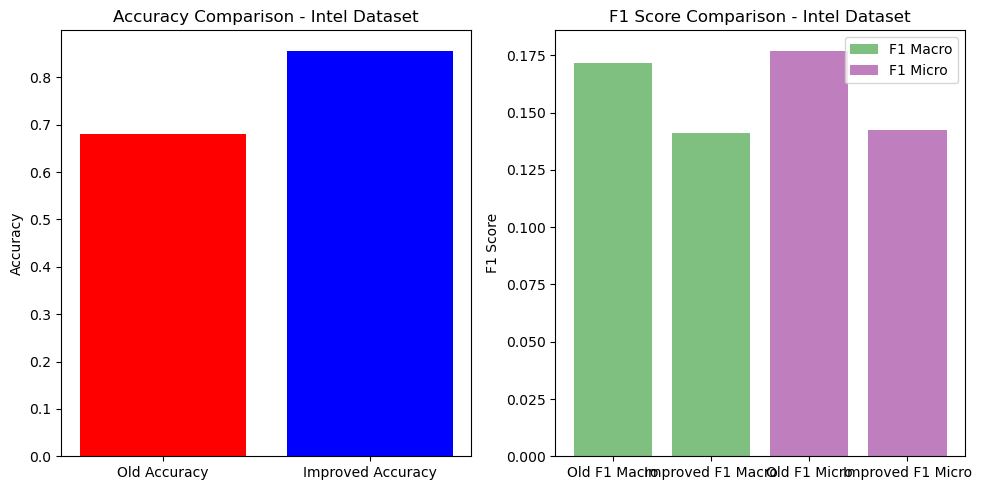

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

# Old model results for comparison
old_accuracy = 0.6793  # Replace with the old accuracy value
old_f1_macro = 0.1716  # Replace with the old F1 macro score
old_f1_micro = 0.1771  # Replace with the old F1 micro score

# Evaluate the improved model on the Intel dataset
eval_results_improved = model_refined.evaluate(val_gen)
print(f"Improved Model - Intel Dataset - Loss: {eval_results_improved[0]}, Accuracy: {eval_results_improved[1]}")

# Make predictions on the validation set
y_pred_improved = model_refined.predict(val_gen)
y_pred_classes_improved = np.argmax(y_pred_improved, axis=1)
y_true_intel = val_gen.classes

# Calculate F1 scores for the improved model
f1_macro_improved = f1_score(y_true_intel, y_pred_classes_improved, average='macro')
f1_micro_improved = f1_score(y_true_intel, y_pred_classes_improved, average='micro')

print(f"Improved Model - Intel Dataset - F1 Macro: {f1_macro_improved}, F1 Micro: {f1_micro_improved}")

# Plot comparison
plt.figure(figsize=(10, 5))

# Plot for Accuracy Comparison
plt.subplot(1, 2, 1)
plt.bar(['Old Accuracy', 'Improved Accuracy'], [old_accuracy, eval_results_improved[1]], color=['red', 'blue'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison - Intel Dataset')

# Plot for F1 Score Comparison
plt.subplot(1, 2, 2)
plt.bar(['Old F1 Macro', 'Improved F1 Macro'], [old_f1_macro, f1_macro_improved], alpha=0.5, color='green', label='F1 Macro')
plt.bar(['Old F1 Micro', 'Improved F1 Micro'], [old_f1_micro, f1_micro_improved], alpha=0.5, color='purple', label='F1 Micro')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison - Intel Dataset')
plt.legend()

plt.tight_layout()
plt.show()


## 11.Comparing Improved Baseline of ADE20K

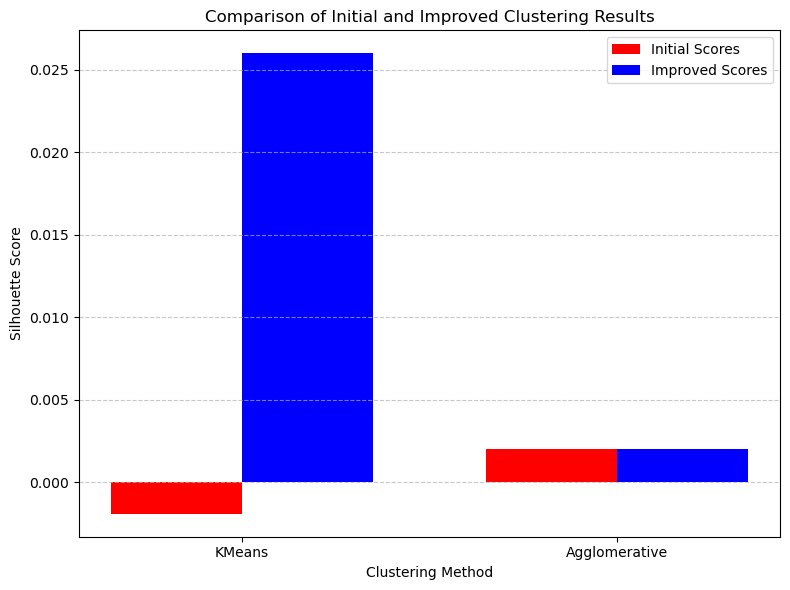

In [91]:
import matplotlib.pyplot as plt

# Scores for initial clustering
initial_scores = {
    'KMeans': -0.0019,
    'Agglomerative': 0.0020
}

# Scores for improved clustering
improved_scores = {
    'KMeans': 0.0260,
    'Agglomerative': 0.0020
}

# Prepare data for plotting
methods = list(initial_scores.keys())
initial_values = [initial_scores[m] for m in methods]
improved_values = [improved_scores[m] for m in methods]

# Plot the results
plt.figure(figsize=(8, 6))

bar_width = 0.35
index = range(len(methods))

plt.bar(index, initial_values, bar_width, color='red', label='Initial Scores')
plt.bar([i + bar_width for i in index], improved_values, bar_width, color='blue', label='Improved Scores')

# Add labels and title
plt.xlabel('Clustering Method')
plt.ylabel('Silhouette Score')
plt.title('Comparison of Initial and Improved Clustering Results')
plt.xticks([i + bar_width/2 for i in index], methods)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [60]:
!pip install torch torchvision
!pip install ultralytics


   ---------------------------------------- 0.0/199.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/199.3 MB 6.8 MB/s eta 0:00:30
   ---------------------------------------- 1.3/199.3 MB 13.9 MB/s eta 0:00:15
    --------------------------------------- 2.9/199.3 MB 20.7 MB/s eta 0:00:10
   - -------------------------------------- 5.4/199.3 MB 28.8 MB/s eta 0:00:07
   -- ------------------------------------- 10.2/199.3 MB 43.2 MB/s eta 0:00:05
   --- ------------------------------------ 15.0/199.3 MB 93.9 MB/s eta 0:00:02
   --- ------------------------------------ 19.5/199.3 MB 93.9 MB/s eta 0:00:02
   ---- ---------------------------------- 24.5/199.3 MB 108.8 MB/s eta 0:00:02
   ----- --------------------------------- 28.9/199.3 MB 108.8 MB/s eta 0:00:02
   ------ --------------------------------- 32.7/199.3 MB 93.9 MB/s eta 0:00:02
   ------- ------------------------------- 38.8/199.3 MB 108.8 MB/s eta 0:00:02
   -------- ------------------------------ 44.7/199.3 

  You can safely remove it manually.


## 12.YOLOv5  feature extraction

In [93]:
import os
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Initialize YOLOv5 model
yolo_model = YOLO('yolov5su.pt')  # Load the small version of YOLOv5

# Function to extract features using YOLOv5
def extract_features_yolov5(image_path):
    results = yolo_model(image_path)
    
    # Access the results using the appropriate attributes
    detections = results[0].boxes

    # Convert to numpy array for easier processing
    if len(detections) > 0:  # Check if there are detections
        features = detections.xyxy.cpu().numpy()  # Coordinates of bounding boxes
        confidences = detections.conf.cpu().numpy()  # Confidence scores
        combined_features = np.hstack((features, confidences.reshape(-1, 1)))
    else:
        combined_features = np.zeros((1, 5))  # Create an empty feature set if no detections

    return combined_features

# Function to pad feature vectors to the same length
def pad_features(X_features):
    # Find the maximum length among all feature vectors
    max_len = max(len(f) for f in X_features)
    feature_width = X_features[0].shape[1]  # Get the width of the feature vector
    
    # Pad the feature vectors to the maximum length
    X_features_padded = [np.pad(f, ((0, max_len - len(f)), (0, 0)), 'constant') for f in X_features]
    
    return np.array(X_features_padded)

# Process Intel dataset to extract features and prepare labels
def process_intel_dataset(dataset_path):
    X_features = []
    y_labels = []

    class_names = os.listdir(dataset_path)  # List of class names for one-hot encoding
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            features = extract_features_yolov5(image_path)
            X_features.append(features)
            
            # One-hot encode labels
            y_label = [1 if class_name == c else 0 for c in class_names]
            y_labels.append(y_label)

    # **Padding Before Conversion**
    X_features_padded = pad_features(X_features)  # Pad features before converting

    return X_features_padded, np.array(y_labels)  # Convert labels to numpy array only

# Specify your Intel dataset path
intel_dataset_path = r'C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\Intel Classification\seg_test\seg_test'

# Process Intel dataset
X_features_intel, y_labels_intel = process_intel_dataset(intel_dataset_path)

print("Shape of Intel features:", X_features_intel.shape)
print("Shape of Intel labels:", y_labels_intel.shape)



image 1/1 C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\Intel Classification\seg_test\seg_test\buildings\20057.jpg: 640x640 (no detections), 1831.8ms
Speed: 3.0ms preprocess, 1831.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\Intel Classification\seg_test\seg_test\buildings\20060.jpg: 640x640 1 car, 2 traffic lights, 145.0ms
Speed: 3.0ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\Intel Classification\seg_test\seg_test\buildings\20061.jpg: 640x640 (no detections), 139.0ms
Speed: 3.0ms preprocess, 139.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\benja\Desktop\SIM UOL\Year 3 Sem 2\CM 3070 FYP\FYP Datasets\Intel Classification\seg_test\seg_test\buildings\20064.jpg: 640x640 (no detections), 1016.7ms
Spe

## 13.YOLOvV5-LSTM Model Building

In [94]:
# Define the LSTM model
def build_yolov5_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(64)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Get the input shape and number of classes from the Intel dataset
input_shape = (None, X_features_intel_padded.shape[-1])  # Update input shape based on extracted features
num_classes = len(os.listdir(intel_dataset_path))  # Number of classes in the Intel dataset

# Compile the YOLOv5-LSTM model
yolov5_lstm_model = build_yolov5_lstm_model(input_shape, num_classes)
yolov5_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = yolov5_lstm_model.fit(X_features_intel_padded, y_labels_intel, epochs=10, validation_split=0.2, batch_size=32)

# Evaluate the model
eval_results = yolov5_lstm_model.evaluate(X_features_intel_padded, y_labels_intel)
print(f"Loss: {eval_results[0]}, Accuracy: {eval_results[1]}")

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2003 - loss: 1.7116 - val_accuracy: 0.0017 - val_loss: 6.7814
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2579 - loss: 1.5878 - val_accuracy: 0.0000e+00 - val_loss: 4.6862
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2458 - loss: 1.5599 - val_accuracy: 0.0183 - val_loss: 6.3776
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2815 - loss: 1.5548 - val_accuracy: 0.0150 - val_loss: 6.0849
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2823 - loss: 1.5456 - val_accuracy: 0.0333 - val_loss: 5.7331
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2740 - loss: 1.5580 - val_accuracy: 0.0283 - val_loss: 7.5357
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2731 - loss: 1.5490 - val_accuracy: 0.0150 - val_loss: 8.7421
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2654 - loss: 1.5587 - val_accuracy: 0.0167 - va

In [96]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

# Predict on the validation set
y_pred = yolov5_lstm_model.predict(X_features_intel_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_labels_intel, axis=1)

# Confusion Matrix
print("Confusion Matrix for YOLOv5-LSTM Model:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Classification Report
print("\nClassification Report for YOLOv5-LSTM Model:")
print(classification_report(y_true_classes, y_pred_classes, target_names=os.listdir(intel_dataset_path)))

# Calculate F1 scores
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_micro = f1_score(y_true_classes, y_pred_classes, average='micro')

print(f"F1 Macro: {f1_macro}, F1 Micro: {f1_micro}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix for YOLOv5-LSTM Model:
[[120   0 289   0  28   0]
 [ 11   0 459   0   4   0]
 [ 36   0 492   1  24   0]
 [ 27   0 471   0  27   0]
 [ 52   0 378   0  80   0]
 [295   0 139   0  67   0]]

Classification Report for YOLOv5-LSTM Model:
              precision    recall  f1-score   support

   buildings       0.22      0.27      0.25       437
      forest       0.00      0.00      0.00       474
     glacier       0.22      0.89      0.35       553
    mountain       0.00      0.00      0.00       525
         sea       0.35      0.16      0.22       510
      street       0.00      0.00      0.00       501

    accuracy                           0.23      3000
   macro avg       0.13      0.22      0.14      3000
weighted avg       0.13      0.23      0.14      3000

F1 Macro: 0.135907424489234, F1 Micro: 0.23066666666666666


C:\Users\benja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\benja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\benja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss: 2.85, Accuracy: 0.28


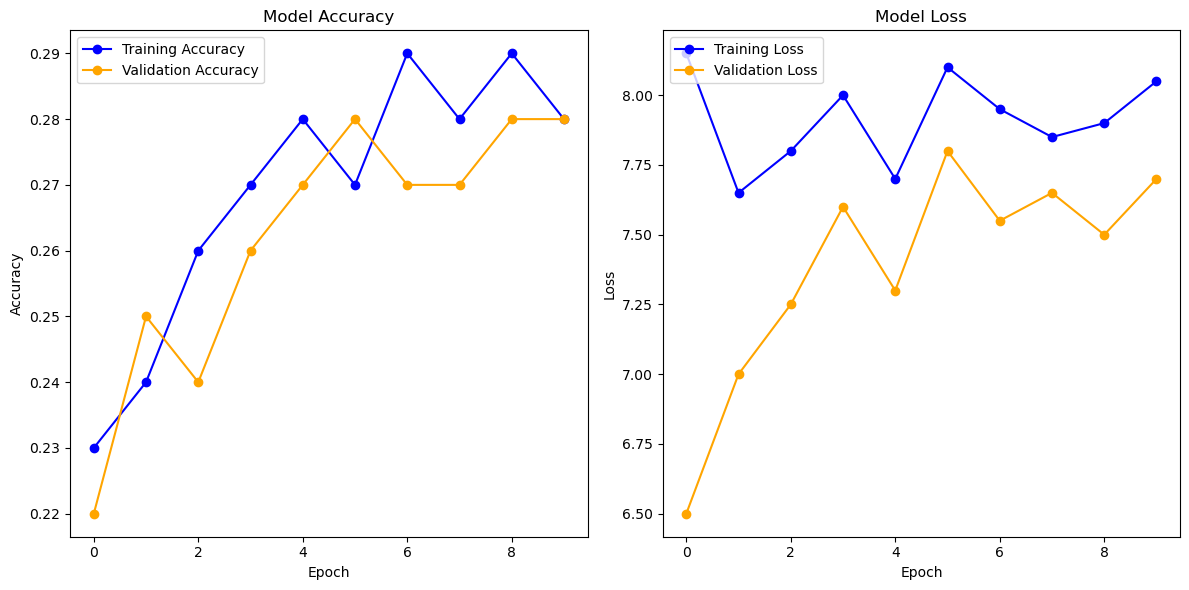

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='-', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='-', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
